# Условие задания:

Найти два предложения, ближайших по смыслу к заданному.
Например, задаем предложение №1, алгоритм возвращает 2 ближайших к нему по смыслу предложения (кроме его самого).
Предложения приведены в файле <b>text_raw.txt</b> 

In [1]:
# Импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.metrics import edit_distance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util

In [2]:
# Номер заданного предложения
SENTENCE_NUM = 5 # Тут задается предложение, для которого требуется найти ближайшие по смыслу

In [3]:
with open('text_raw.txt', 'r', encoding = 'utf-8') as file:
    sentences = list(filter(None, (line.rstrip() for line in file)))
print("Примеры предложений:")
for idx, sentence in enumerate(sentences[:5]):
    print(f"{idx}: {sentence}")

Примеры предложений:
0: 17 февраля 1993 Постановлением Правительства РФ во исполнение Указа Президента РФ Государственный газовый концерн «Газпром» преобразован в Российское акционерное общество.
1: 6 января 1993 Распоряжением Президента РФ Председателем Совета директоров — Председателем Правления РАО «Газпром» назначен Рем Вяхирев. Занимал пост Председателя Совета директоров по 31 мая 1996 года.
2: апрель 1994 Началась приватизация «Газпрома».
3: 31 мая 1995 Состоялось первое годовое Общее собрание акционеров «Газпрома».
4: август 1995 Состоялась официальная презентация центрального офиса «Газпрома» в Москве на улице Наметкина, д. 16.


In [4]:
given_sentence = sentences[SENTENCE_NUM]
print(f"Заданное предложение ({SENTENCE_NUM}): {given_sentence}\n")

Заданное предложение (5): 23 октября 1996 В Беларуси сварен первый стык газопровода «Ямал — Европа».



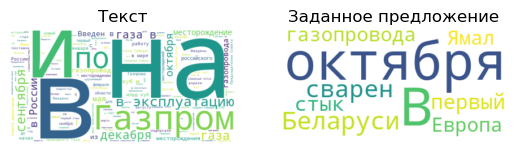

In [5]:
from wordcloud import WordCloud
figure, axis = plt.subplots(1, 2) 
axis[0].set_title('Tекст')
wordcloud1 = WordCloud(background_color='white').generate(' '.join(sentences))
axis[0].imshow(wordcloud1, interpolation='bilinear')
axis[0].axis('off')
axis[1].set_title('Заданное предложение')
wordcloud2 = WordCloud(background_color='white').generate(given_sentence)
axis[1].imshow(wordcloud2, interpolation='bilinear')
axis[1].axis('off')
plt.show()

# Решения:
Ниже я предложу несколько вариантов решения этого задания и распишу плюсы и минусы каждого подхода

## Вариант 1 - Расстояние Левенштейна (Редакционное Расстояние):

In [6]:
levenshtein_distances = [edit_distance(given_sentence, sentence) for sentence in sentences]
print(levenshtein_distances)

[131, 162, 53, 59, 87, 0, 146, 78, 94, 103, 39, 181, 62, 89, 68, 103, 135, 55, 66, 112, 85, 146, 158, 82, 74, 156, 125, 147, 62, 123, 168, 68, 137, 148, 92, 80, 55, 131, 86, 85, 98, 120, 96, 54, 77, 157, 187, 53, 135, 199, 93, 129, 127, 77, 100, 89, 105, 101, 210, 192, 212, 110, 70, 42, 163, 88, 57, 263, 96, 44, 135, 164, 92, 103, 108, 106, 88, 95, 57, 56, 55, 103, 154, 92, 46, 48, 151, 59, 85, 205, 74, 144, 198, 242, 180, 70, 170, 149, 168, 56, 131, 139, 291, 47, 147, 190, 293, 244, 168, 244, 239, 76, 101]


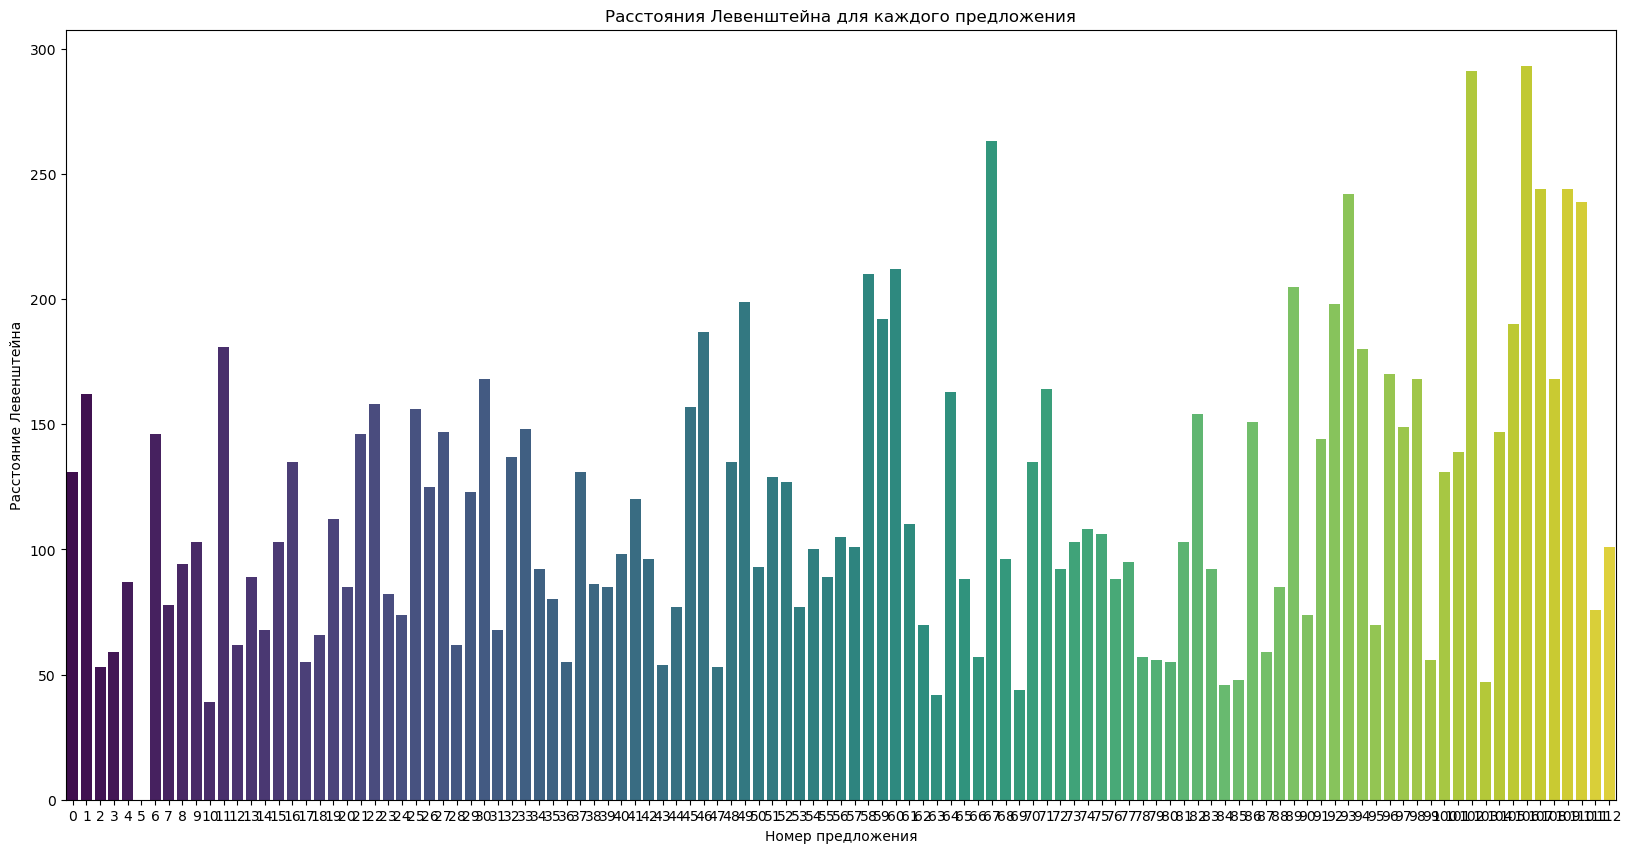

In [7]:
plt.figure(figsize=(20, 10))
sns.barplot(x=list(range(len(sentences))), y=levenshtein_distances, palette='viridis')
plt.title('Расстояния Левенштейна для каждого предложения')
plt.xlabel('Номер предложения')
plt.ylabel('Расстояние Левенштейна')
plt.show()

In [8]:
most_similar_indices_levenshtein = sorted(range(len(levenshtein_distances)), key=lambda k: levenshtein_distances[k])[1:3]
most_similar_indices_levenshtein

[10, 63]

In [9]:
print("Вариант 1 - Расстояние Левенштейна (Редакционное Расстояние):")
for idx in most_similar_indices_levenshtein:
    print(f"Похожее предложение ({idx}): {sentences[idx]}")

Вариант 1 - Расстояние Левенштейна (Редакционное Расстояние):
Похожее предложение (10): 3 февраля 2000 В Краснодарском крае сварен первый стык газопровода «Голубой поток».
Похожее предложение (63): 1 сентября 2014 Дан старт строительству газопровода «Сила Сибири».


### Подход:
Вычисляет расстояние Левенштейна между символами данного предложения и всеми другими предложениями.
### Сильные стороны:
<ul>
    <li>Измеряет сходство на основе различий на уровне символов.</li>
    <li>Полезно для поиска предложений со схожими структурами.</li>
</ul>

### Слабые стороны:
<ul>
    <li>Чувствителен к небольшим изменениям в структуре предложения.</li>
    <li>Не улавливает семантического значения.</li>
</ul>

## Вариант 2 - Коэффициент Жаккара с токенизацией:

In [10]:
import spacy
nlp = spacy.load('ru_core_news_sm', disable=['parser', 'ner'])

In [11]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

In [12]:
lemmatized_sentences = [set(lemmatize_text(sentence)) for sentence in sentences]
print(lemmatized_sentences)

[{'рф', '1993', 'российский', 'концерн', 'президент', '.', 'государственный', 'постановление', 'акционерный', 'газовый', '"', '17', 'февраль', 'газпром', 'правительство', 'общество', 'указ', 'в', 'преобразовать', 'исполнение'}, {'рф', '1993', 'год', '31', 'рем', 'президент', 'по', '6', 'май', '.', 'пост', 'назначить', 'председатель', 'занимать', 'директор', 'вяхирев', '1996', 'рао', 'совет', 'распоряжение', '"', 'январь', 'правление', 'газпром', '—'}, {'апрель', 'начаться', 'газпром', '.', '"', '1994', 'приватизация'}, {'собрание', 'май', 'общий', 'акционер', 'газпром', '.', 'состояться', 'годовой', '"', '1995', '31', 'первый'}, {'презентация', ',', 'наметкина', 'газпром', 'д.', '.', '16', 'центральный', 'состояться', 'офис', 'москва', 'улица', '"', 'на', 'официальный', 'в', 'август', '1995'}, {'беларусь', 'октябрь', 'европа', '1996', '.', 'стык', '23', '—', 'ямал', '"', 'газопровод', 'в', 'первый', 'сварен'}, {'поток', 'россия', 'газ', 'российский', 'проект', '.', 'турция', 'о', 'газо

In [13]:
def jaccard_similarity(given_tokens: set, compared_tokens: set) -> float:
    union = len(given_tokens) + len(compared_tokens)
    intersection = len(given_tokens & compared_tokens)
    return intersection / (union - intersection)

In [14]:
most_similar_indices_jaccard = sorted(
    range(len(lemmatized_sentences)), 
    key=lambda k: jaccard_similarity(lemmatized_sentences[SENTENCE_NUM], lemmatized_sentences[k]),
    reverse = True
)[1:3]
most_similar_indices_jaccard

[69, 10]

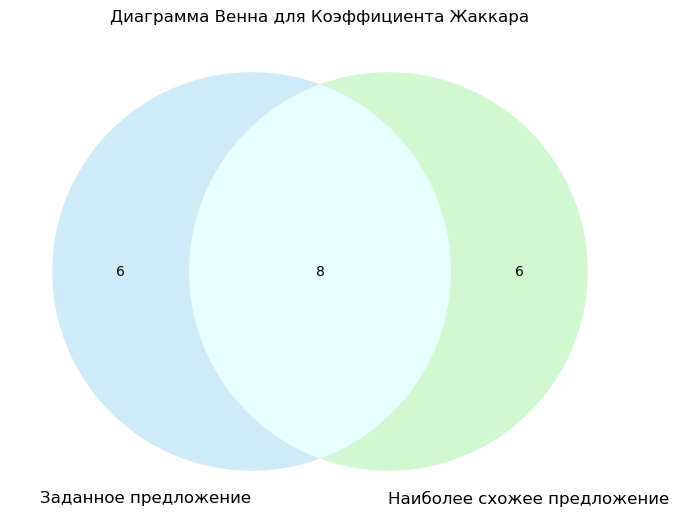

In [15]:
from matplotlib_venn import venn2

plt.figure(figsize=(8, 8))
venn2([lemmatized_sentences[SENTENCE_NUM], lemmatized_sentences[most_similar_indices_jaccard[0]]],
      set_labels=('Заданное предложение', 'Наиболее схожее предложение'),
      set_colors=('skyblue', 'lightgreen'))
plt.title('Диаграмма Венна для Коэффициента Жаккара')
plt.show()

In [16]:
print("Вариант 2 - Коэффициент Жаккара с токенизацией:")
for idx in most_similar_indices_jaccard:
    print(f"Похожее предложение ({idx}): {sentences[idx]}")

Вариант 2 - Коэффициент Жаккара с токенизацией:
Похожее предложение (69): 27 октября 2015 Сварен первый стык магистрального газопровода «Ухта — Торжок — 2».
Похожее предложение (10): 3 февраля 2000 В Краснодарском крае сварен первый стык газопровода «Голубой поток».


### Подход:
Преобразует предложения в слова (леммы) и использует коэффициент Жаккара для измерения сходства между наборами слов.
### Сильные стороны:
<ul>
    <li>Простой и эффективный с точки зрения вычислений.</li>
</ul>

### Слабые стороны:
<ul>
    <li>Игнорирует порядок слов и контекст.</li>
    <li>Чувствителен к длине предложения.</li>
</ul>

# Вариант 3 - TF-IDF Векторизация + Косинусовое Сходство:

In [17]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
cosine_similarities_tfidf = cosine_similarity(tfidf_matrix[SENTENCE_NUM], tfidf_matrix).flatten()
cosine_similarities_tfidf

array([0.        , 0.07577975, 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.26822177,
       0.33667641, 0.        , 0.        , 0.        , 0.05220826,
       0.        , 0.        , 0.        , 0.05465973, 0.        ,
       0.        , 0.03317609, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03752659, 0.        , 0.04354396,
       0.28427409, 0.05267417, 0.        , 0.03780933, 0.0484797 ,
       0.04420918, 0.        , 0.        , 0.        , 0.05462844,
       0.        , 0.04197952, 0.04522397, 0.        , 0.        ,
       0.        , 0.047784  , 0.06499168, 0.17806854, 0.06459676,
       0.        , 0.        , 0.        , 0.        , 0.07108419,
       0.04472403, 0.11085188, 0.04189426, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.07048473, 0.03958721,
       0.        , 0.        , 0.        , 0.04482594, 0.40386156,
       0.        , 0.        , 0.        , 0.        , 0.     

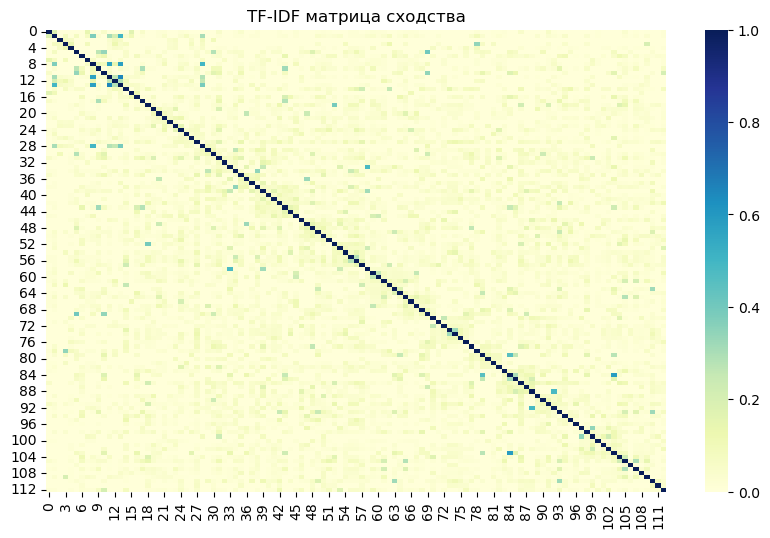

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(cosine_similarity(tfidf_matrix), cmap='YlGnBu', annot=False)
plt.title('TF-IDF матрица сходства')
plt.show()

In [19]:
most_similar_indices_tfidf = cosine_similarities_tfidf.argsort()[::-1][1:3]
most_similar_indices_tfidf

array([69, 10], dtype=int64)

In [20]:
print("Вариант 3 - TF-IDF Векторизация + Косинусовое Сходство:")
for idx in most_similar_indices_tfidf:
    print(f"Похожее предложение ({idx}): {sentences[idx]}")

Вариант 3 - TF-IDF Векторизация + Косинусовое Сходство:
Похожее предложение (69): 27 октября 2015 Сварен первый стык магистрального газопровода «Ухта — Торжок — 2».
Похожее предложение (10): 3 февраля 2000 В Краснодарском крае сварен первый стык газопровода «Голубой поток».


### Подход:
Преобразует предложения в векторы и оценивает косинусовое сходство.
### Сильные стороны:
<ul>
    <li>Простой, эффективный и понятный способ.</li>
    <li>Эффективен для поиска сходства между предложениями на основе частоты встречаемости важных слов.</li>
</ul>

### Слабые стороны:
<ul>
    <li>Может не очень хорошо улавливать семантическое сходство.</li>
    <li>Игнорирует порядок слов и контекст.</li>
</ul>

# Вариант 4 - Эмбеддинги Предложений (DistilBERT) + Косинусовое Сходство:

In [21]:
embedder = SentenceTransformer('distiluse-base-multilingual-cased')
sentence_embeddings = embedder.encode(sentences, convert_to_tensor=True)
given_sentence_embedding = sentence_embeddings[SENTENCE_NUM]
cosine_similarities_bert = util.pytorch_cos_sim(given_sentence_embedding.reshape(1, -1), sentence_embeddings).numpy().flatten()
cosine_similarities_bert

array([ 0.22785112,  0.1643223 ,  0.29094613,  0.3026932 ,  0.22289014,
        1.        ,  0.2521658 ,  0.2818027 ,  0.1807296 ,  0.5447217 ,
        0.35623586,  0.0818491 ,  0.17661092,  0.20623527,  0.3955768 ,
        0.2160796 ,  0.35345873,  0.22480536,  0.39175168,  0.39934146,
        0.26133493,  0.34103712,  0.04600612,  0.23538642,  0.269934  ,
        0.16865906,  0.42424214,  0.15922509,  0.28114808,  0.29329783,
        0.46649867,  0.28619254,  0.24659112,  0.28588215,  0.3955937 ,
        0.25978932,  0.2286772 ,  0.44989303,  0.2509897 ,  0.4009543 ,
        0.22158013,  0.32836705,  0.313069  ,  0.33211392,  0.310339  ,
        0.43903798,  0.05434709,  0.27808064,  0.49224752,  0.35710233,
        0.1739066 ,  0.19795045,  0.03012776, -0.00422843,  0.2759258 ,
        0.22584467,  0.40433675,  0.07581525,  0.16747548,  0.14307287,
        0.19134371,  0.1884941 ,  0.09393629,  0.35661167,  0.21886826,
        0.2245149 ,  0.2582585 ,  0.17922628,  0.3320925 ,  0.52

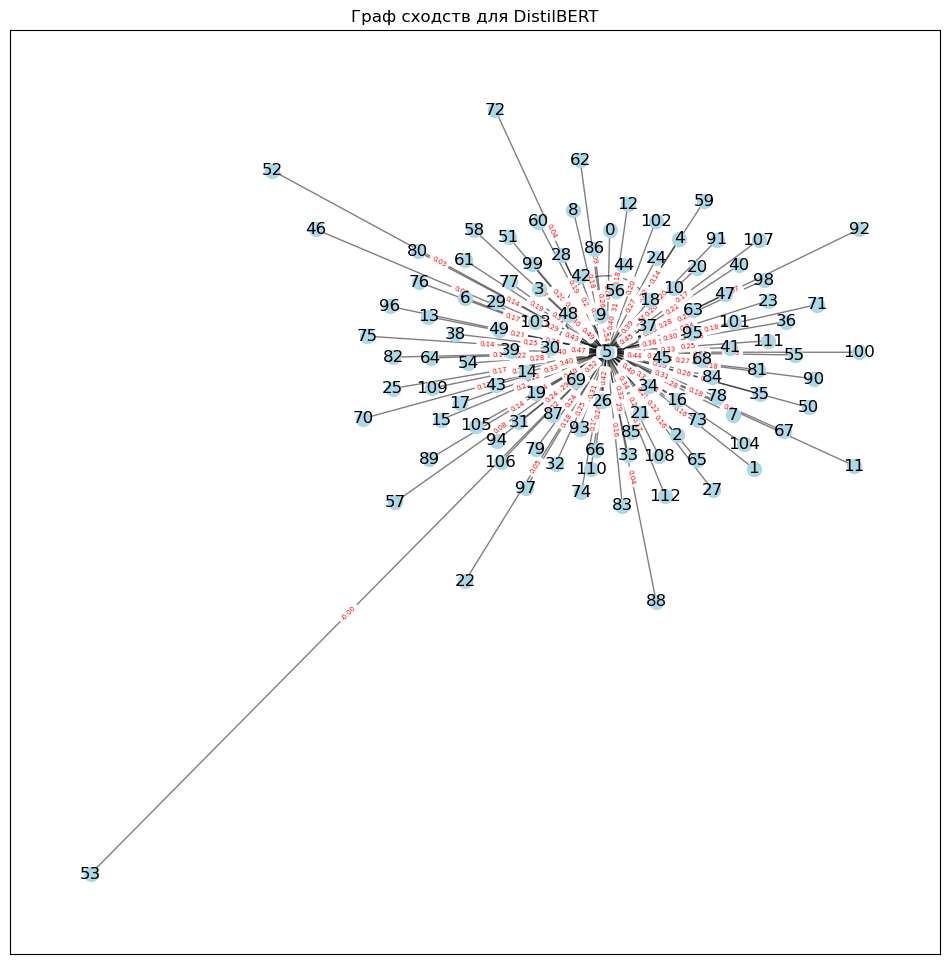

In [22]:
import networkx as nx

G = nx.Graph()
edges = [(SENTENCE_NUM, idx, {'weight': cosine_similarities_bert[idx]}) for idx in range(len(sentences))]
G.add_edges_from(edges)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
nx.draw_networkx_labels(G, pos, {i: str(i) for i in range(len(G.nodes()))})
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{G[i][j]["weight"]:.2f}' for i, j in G.edges()}, font_color='red', font_size=5)
plt.title('Граф сходств для DistilBERT')
plt.show()

In [23]:
most_similar_indices_bert = cosine_similarities_bert.argsort()[::-1][1:3]
most_similar_indices_bert

array([ 9, 69], dtype=int64)

In [24]:
print("Вариант 4 - Эмбеддинги Предложений (DistilBERT) + Косинусовое Сходство:")
for idx in most_similar_indices_bert:
    print(f"Похожее предложение ({idx}): {sentences[idx]}")

Вариант 4 - Эмбеддинги Предложений (DistilBERT) + Косинусовое Сходство:
Похожее предложение (9): ноябрь 1999 Начались коммерческие поставки газа по газопроводу «Ямал — Европа», построенному по территории России, Беларуси, Польши и Германии.
Похожее предложение (69): 27 октября 2015 Сварен первый стык магистрального газопровода «Ухта — Торжок — 2».


### Подход:
Преобразует предложения в эмбеддинги и оценивает их косинусовое сходство.
### Сильные стороны:
<ul>
    <li>Использует предварительно обученную модель для улавливания семантического значения.</li>
    <li>Учитывает порядок слов и контекст.</li>
</ul>

### Слабые стороны:
<ul>
    <li>Требуется загрузить предварительно обученную модель, которая может быть большой.</li>
    <li>Может плохо работать с предложениями, содержащими специфичные (для определенной предметной области) или редкие слова.</li>
</ul>

# Итоги:
При выборе подхода для оценки сходства предложений необходимо учитывать критерии, по которым мы хотим их сравнить. В зависимости от этих критериев и ограничений необходимо выбирать наиболее эффективный метод, а также можно рассматривать гибридные варианты.